In [1]:
# Grab example data
# !wget

# Set up environment
# !pip install probeinterface spikeinterface

In [1]:
# Import necessary packages
import numpy as np
import matplotlib.pyplot as plt
import spikeinterface.extractors as se
import probeinterface
import probeinterface.plotting

c:\Users\open-ephys\Desktop\load-np1e\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Parameters
suffix = 0                                    # Change to match file names' suffix
start_t = 5.0                                 # When to start plotting ephys data (second)
dur = 1.0                                     # Duration of ephys data to plot (seconds)
plot_num_channels = 10                        # Number of channels to plot
probeinterface_filename = 'np2-config.json'   # Change this to the name of your probeinterface file

# Constants
acq_clk_hz = 250e6
fs_hz = 30e3
gain_to_uV = 3.05176
offset_to_uV = -2048 * gain_to_uV
num_channels = 384

In [3]:
# Load acqusition session data
dt = {'names': ('time', 'acq_clk_hz', 'block_read_sz', 'block_write_sz'),
      'formats': ('datetime64[us]', 'u4', 'u4', 'u4')}
meta = np.genfromtxt(f'/content/start-time_{suffix}.csv', delimiter=',', dtype=dt, skip_header=1)
print(f"Recording was started at {meta['time']} GMT")

FileNotFoundError: /content/start-time_0.csv not found.

In [14]:
# Load Neuropixels 2.0 clock data
time = np.fromfile(f'/content/np2-a-clock_{suffix}.raw', dtype=np.uint64).astype(np.double) / acq_clk_hz

# Load and scale Neuropixels 2.0 ephys data
rec = se.read_binary(f'/content/np2-a-ephys_{suffix}.raw',
                        sampling_frequency=fs_hz,
                        dtype=np.uint16,
                        num_channels=num_channels,
                        gain_to_uV=gain_to_uV,
                        offset_to_uV=offset_to_uV)
rec_scaled = rec.get_traces(return_scaled=False, channel_ids=np.arange(plot_num_channels))

# Truncate data based on start_t & dur
b = np.bitwise_and(time >= start_t, time < start_t + dur)
rec_scaled_truncated = rec_scaled[b]
time_truncated = time[b]

Text(0, 0.5, 'Voltage (µV)')

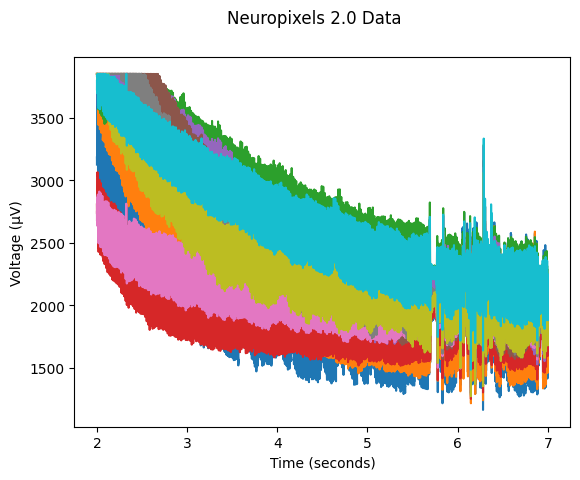

In [21]:
# Plot ephys data
fig = plt.figure()
fig.suptitle('Neuropixels 2.0 Data')
plt.plot(time_truncated, rec_scaled_truncated)
plt.xlabel("Time (seconds)")
plt.ylabel("Voltage (µV)")

In [22]:
# Load BNO055 data
dt = {'names': ('euler', 'quat', 'is_quat_id', 'accel', 'grav', 'temp', 'calibration', 'clock'),
      'formats': ('(1,3)f8', '(1,4)f8', '?', '(1,3)f8', '(1,3)f8', 'f8', '?', 'u8')}
bno055 = np.genfromtxt(f'/content/bno055_{suffix}.csv', delimiter=',', dtype=dt)

# Load BNO055 clock data
bno055_time = bno055['clock'] / acq_clk_hz

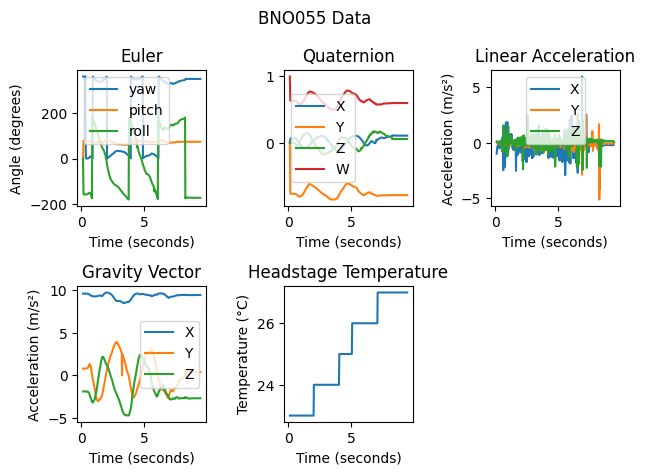

In [23]:
# Plot BNO055 data
fig = plt.figure()
fig.suptitle('BNO055 Data')
plt.subplot(231)

plt.plot(bno055_time, bno055['euler'].squeeze())
plt.xlabel("Time (seconds)")
plt.ylabel("Angle (degrees)")
plt.legend(['yaw', 'pitch', 'roll'])
plt.title('Euler')

plt.subplot(232)
plt.plot(bno055_time, bno055['quat'].squeeze())
plt.xlabel("Time (seconds)")
plt.legend(['X', 'Y', 'Z', 'W'])
plt.title('Quaternion')

plt.subplot(233)
plt.plot(bno055_time, bno055['accel'].squeeze())
plt.xlabel("Time (seconds)")
plt.ylabel("Acceleration (m/s\u00b2)")
plt.legend(['X', 'Y', 'Z'])
plt.title('Linear Acceleration')

plt.subplot(234)
plt.plot(bno055_time, bno055['grav'].squeeze())
plt.xlabel("Time (seconds)")
plt.ylabel("Acceleration (m/s\u00b2)")
plt.legend(['X', 'Y', 'Z'])
plt.title('Gravity Vector')

plt.subplot(235)
plt.plot(bno055_time, bno055['temp'].squeeze())
plt.xlabel("Time (seconds)")
plt.ylabel("Temperature (°C)")
plt.title('Headstage Temperature')

plt.tight_layout()

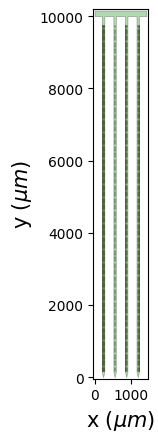

In [24]:
# Load and plot Neuropixels 2.0 probeinterface probe group
np2_config = probeinterface.io.read_probeinterface('/content/np2-config.json')
probeinterface.plotting.plot_probegroup(np2_config, show_channel_on_click=True)